In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Reading the data from Data folder and understanding
ab_test = pd.read_csv("Data/ab_test.csv")
ab_test = ab_test.rename(columns={"id":"user_id", "con_treat":"group", "page": "landing_page"})
print(ab_test.head())

   user_id     time      group landing_page  converted
0   851104  11:48.6    control     old_page          0
1   804228  01:45.2    control     old_page          0
2   661590  55:06.2  treatment     new_page          0
3   853541  28:03.1  treatment     new_page          0
4   864975  52:26.2    control     old_page          1


In [3]:
print(f"Dataset size: {ab_test.shape}")
print(f"Number of unique users: {ab_test.user_id.nunique()}")

Dataset size: (294478, 5)
Number of unique users: 290584


In [4]:
print(ab_test.info())
print()
print(ab_test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   time          294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None

user_id         0
time            0
group           0
landing_page    0
converted       0
dtype: int64


In [5]:
# Checking duplicate user_ids
print(f"Duplicated user_id found: {ab_test["user_id"].duplicated().any()}")

Duplicated user_id found: True


landing_page  new_page  old_page     All
group                                   
control           1928    145274  147202
treatment       145311      1965  147276
All             147239    147239  294478


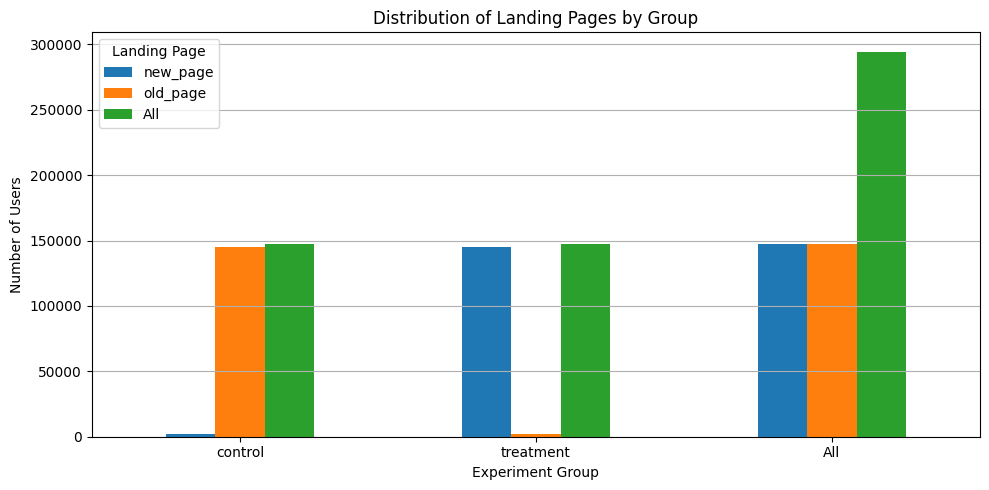

In [6]:
# Checking the data mismatch
crosstabDF = pd.crosstab(ab_test.group, ab_test.landing_page, margins=True)
print(crosstabDF)

# Crosstab plot
crosstabDF.plot.bar(figsize=(10,5))
plt.title("Distribution of Landing Pages by Group")
plt.xlabel("Experiment Group")
plt.ylabel("Number of Users")
plt.legend(title="Landing Page")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [7]:
mismatch_mask = (
    ((ab_test["group"] == "treatment") & (ab_test["landing_page"] == "old_page")) |
    ((ab_test["group"] == "control") & (ab_test["landing_page"] == "new_page")))
n_mismatch = len(ab_test[mismatch_mask])
print(f"Number of data mismatch: {n_mismatch}")
print(f"Data mismatch percentage: {round(n_mismatch/len(ab_test)*100, 2)}%")

Number of data mismatch: 3893
Data mismatch percentage: 1.32%


In [8]:
# Removing mismatched rows
ab_test_cleaned = ab_test[~mismatch_mask].copy()

# Checking duplicate user_ids in cleaned dataset
print(f"Duplicated user_id found after removing mismatched rows: {ab_test_cleaned["user_id"].duplicated().any()}")

Duplicated user_id found after removing mismatched rows: True


In [9]:
# Dropping duplicte user_ids, keeping the first occurrence
ab_test_cleaned = ab_test_cleaned.drop_duplicates(subset = "user_id")

# Checking cleaned dataset
print(f"Cleaned dataset shape: {ab_test_cleaned.shape}")
print("Cleaned dataset's group value count and means:")
print(ab_test_cleaned["group"].value_counts())
print(ab_test_cleaned.groupby("group")["converted"].mean())

Cleaned dataset shape: (290584, 5)
group
treatment    145310
control      145274
Name: count, dtype: int64
group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


In [10]:
# Group-level conversion stats
conversion_sum = ab_test_cleaned.groupby("group")["converted"].agg(["sum", "count"])
print(conversion_sum)

converted = conversion_sum["sum"].values
n_obs = conversion_sum["count"].values

             sum   count
group                   
control    17489  145274
treatment  17264  145310


In [11]:
# Performing two-proportion Z-test
z_score, p_value = proportions_ztest(count=converted, nobs=n_obs, alternative='two-sided')

# Results
print("Conversion rates:")
print(conversion_sum["sum"]/conversion_sum["count"])
print()
print("Z-score:", round(z_score, 4))
print("P-value:", round(p_value, 4))

Conversion rates:
group
control      0.120386
treatment    0.118808
dtype: float64

Z-score: 1.3109
P-value: 0.1899


In [12]:
# Reading countries data from Data folder and merging
countries = pd.read_csv("Data/countries_ab.csv")
countries = countries.rename(columns={"id":"user_id"})

merged_df = pd.merge(ab_test_cleaned, countries, on="user_id")
print(merged_df.head())

   user_id     time      group landing_page  converted country
0   851104  11:48.6    control     old_page          0      US
1   804228  01:45.2    control     old_page          0      US
2   661590  55:06.2  treatment     new_page          0      US
3   853541  28:03.1  treatment     new_page          0      US
4   864975  52:26.2    control     old_page          1      US


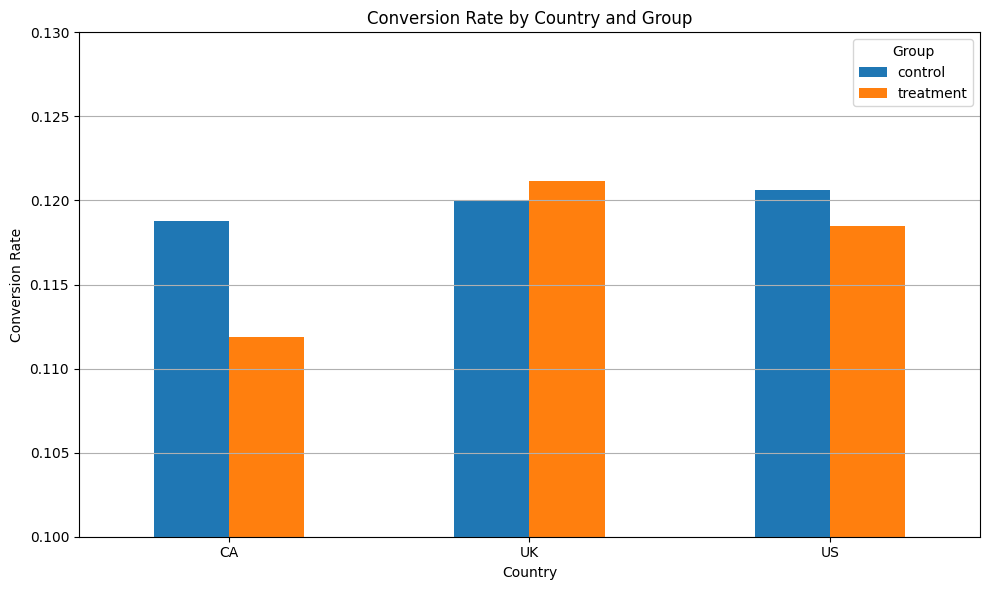

In [13]:
# Calculating conversion rate by country and group
conversion_by_country = merged_df.groupby(['country', 'group'])['converted'].agg(['sum', 'count']).reset_index()
conversion_by_country['conversion_rate'] = conversion_by_country['sum'] / conversion_by_country['count']

# Pivoting the dataset for easier plotting
pivot_df = conversion_by_country.pivot(index='country', columns='group', values='conversion_rate')

# Plot
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Conversion Rate by Country and Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Country')
plt.legend(title='Group')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.ylim(0.10, 0.13)
plt.tight_layout()
plt.show()

In [14]:
# Prepare data for Z-test
country_group_summary = merged_df.groupby(["country", "group"])["converted"].agg(["sum", "count"]).reset_index()
country_test_data = country_group_summary.pivot(index="country", columns="group", values=["sum", "count"])

# Z-test for each country
z_test_results = []
for country in country_test_data.index:
    conversions = country_test_data.loc[country, ("sum", "control")], country_test_data.loc[country, ("sum", "treatment")]
    sample_sizes = country_test_data.loc[country, ("count", "control")], country_test_data.loc[country, ("count", "treatment")]
    z, p = proportions_ztest(count=conversions, nobs=sample_sizes, alternative='two-sided')
    z_test_results.append({
        "country": country,
        "control_cr": conversions[0] / sample_sizes[0],
        "treatment_cr": conversions[1] / sample_sizes[1],
        "z_score": z,
        "p_value": p
    })

# Convert to DataFrame and sort
z_test_df = pd.DataFrame(z_test_results).sort_values("p_value").reset_index(drop=True)
print(z_test_df)

  country  control_cr  treatment_cr   z_score   p_value
0      US    0.120630      0.118466  1.505193  0.132274
1      CA    0.118783      0.111902  1.296900  0.194666
2      UK    0.120022      0.121171 -0.474891  0.634865


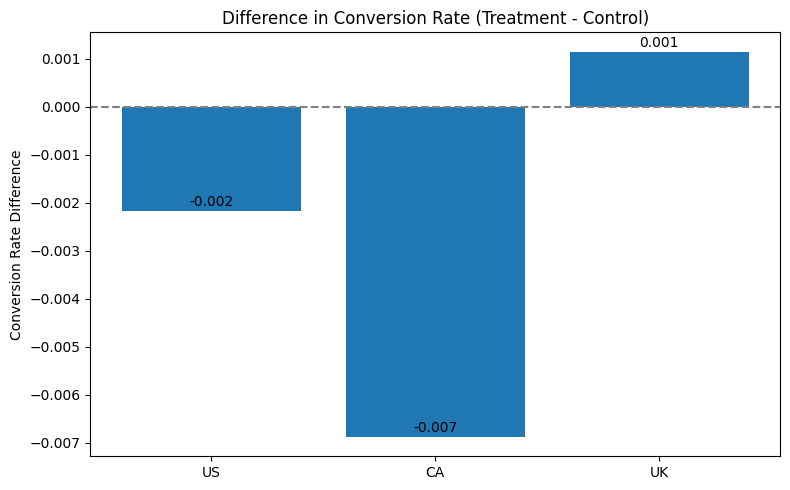

In [15]:
# Country wise difference in conversion rates
diff_df = z_test_df.copy()
diff_df['diff'] = diff_df['treatment_cr'] - diff_df['control_cr']

plt.figure(figsize=(8, 5))
bars = plt.bar(diff_df['country'], diff_df['diff'])
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Conversion Rate (Treatment - Control)')
plt.ylabel('Conversion Rate Difference')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+0.0001, f"{yval:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()